# Pretrain CNN (ResNet) for Regression (Image Size: 128)

In [29]:
import h5py
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import timeit
import torch
import torch.nn as nn
import torch.nn.functional as F

## Step 1 - Preparations

Set paths, environment variables, data and model configurations and training hyperparameters.

In [30]:
# Data and model paths
DATA_PATH = "/home/ubuntu/Desktop/Ra/datasets/Ra_128_indexed_binned.h5"
MODEL_PATH = "/home/ubuntu/Desktop/Ra/models/ResNet_128_regression.pth"
OUTPUT_PATH = "/home/ubuntu/Desktop/Ra/outputs/ResNet_128_regression.csv"
# Env
SEED = 42
NUM_WORKERS = 0
# Data
IMG_SIZE = 128
MIN_LABEL = 1.3
MAX_LABEL = 5.2
TEST_SIZE = 0.2
# Model
CNN = "ResNet34_regre"
# Hyperparameters
EPOCHS = 20
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_VALID = 10
BASE_LR = 0.01
LR_WEIGHT_DECAY = 1e-4
MOMENTUM = 0.9

Create directory `os.path.dirname(MODEL_PATH)` if not existed.

In [31]:
# Path
if not os.path.exists(os.path.dirname(MODEL_PATH)):
    os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
    print(f"Make new directory {os.path.dirname(MODEL_PATH)}")

Set `SEED` globally.

In [32]:
# Seed
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)
print(f"Random Seed: {SEED}")

Random Seed: 42


Set `device` as "cuda" if available, otherwise use "cpu".

In [33]:
# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
ngpu = torch.cuda.device_count()
print(f"Device: {device}")
print(f"Device Count: {ngpu}")

Device: cuda
Device Count: 1


Define an `IMGs_dataset` class, which is an inherit of class `torch.utils.data.Dataset`. `IMGs_dataset` is a class for storing images and labels at the same place, we will use it to initialize the data loader.

In [34]:
class IMGs_dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        super(IMGs_dataset, self).__init__()
        self.images = images
        self.labels = labels

    def __getitem__(self, index):
        images = self.images[index]
        labels = self.labels[index]
        return images, labels

    def __len__(self):
        return len(self.images)

After that we define five different ResNet regression classes: 

1. `ResNet18_regre`
2. `ResNet34_regre`
3. `ResNet50_regre`
4. `ResNet101_regre`
5. `ResNet152_regre`

These classes are only suitable for image size 128. The variable `CNN` shows which model will be used.

In [35]:
class _BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(_BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class _Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(_Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class _ResNet_regre(nn.Module):
    def __init__(self, block, num_blocks, nc=3, ngpu=1, feature_layer="f3"):
        super(_ResNet_regre, self).__init__()
        self.in_planes = 64
        self.ngpu = ngpu
        self.feature_layer = feature_layer

        self.block1 = nn.Sequential(
            nn.Conv2d(nc, 64, kernel_size=3, stride=1, padding=1, bias=False),  # h=h
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # h=h/2 64
            self._make_layer(block, 64, num_blocks[0], stride=2),  # h=h/2 32
        )
        self.block2 = self._make_layer(block, 128, num_blocks[1], stride=2)  # h=h/2 16
        self.block3 = self._make_layer(block, 256, num_blocks[2], stride=2)  # h=h/2 8
        self.block4 = self._make_layer(block, 512, num_blocks[3], stride=2)  # h=h/2 4

        self.pool1 = nn.AvgPool2d(kernel_size=4)
        if self.feature_layer == "f2":
            self.pool2 = nn.AdaptiveAvgPool2d((2, 2))
        elif self.feature_layer == "f3":
            self.pool2 = nn.AdaptiveAvgPool2d((2, 2))
        else:
            self.pool2 = nn.AdaptiveAvgPool2d((1, 1))

        linear_layers = [
            nn.Linear(512 * block.expansion, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1),
            # nn.Sigmoid()
            nn.ReLU(),
        ]
        self.linear = nn.Sequential(*linear_layers)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):

        if x.is_cuda and self.ngpu > 1:
            ft1 = nn.parallel.data_parallel(self.block1, x, range(self.ngpu))
            ft2 = nn.parallel.data_parallel(self.block2, ft1, range(self.ngpu))
            ft3 = nn.parallel.data_parallel(self.block3, ft2, range(self.ngpu))
            ft4 = nn.parallel.data_parallel(self.block4, ft3, range(self.ngpu))
            out = nn.parallel.data_parallel(self.pool1, ft4, range(self.ngpu))
            out = out.view(out.size(0), -1)
            out = nn.parallel.data_parallel(self.linear, out, range(self.ngpu))
        else:
            ft1 = self.block1(x)
            ft2 = self.block2(ft1)
            ft3 = self.block3(ft2)
            ft4 = self.block4(ft3)
            out = self.pool1(ft4)
            out = out.view(out.size(0), -1)
            out = self.linear(out)

        if self.feature_layer == "f2":
            ext_features = self.pool2(ft2)
        elif self.feature_layer == "f3":
            ext_features = self.pool2(ft3)
        else:
            ext_features = self.pool2(ft4)

        ext_features = ext_features.view(ext_features.size(0), -1)

        return out, ext_features


def ResNet18_regre(ngpu=1):
    return _ResNet_regre(_BasicBlock, [2, 2, 2, 2], ngpu=ngpu)


def ResNet34_regre(ngpu=1):
    return _ResNet_regre(_BasicBlock, [3, 4, 6, 3], ngpu=ngpu)


def ResNet50_regre(ngpu=1):
    return _ResNet_regre(_BasicBlock, [3, 4, 6, 3], ngpu=ngpu)


def ResNet101_regre(ngpu=1):
    return _ResNet_regre(_BasicBlock, [3, 4, 23, 3], ngpu=ngpu)


def ResNet152_regre(ngpu=1):
    return _ResNet_regre(_BasicBlock, [3, 8, 36, 3], ngpu=ngpu)


print("Defined 5 different ResNet regression class for image size 128. ")

Defined 5 different ResNet regression class for image size 128. 


## Step 2 - Load and process datasets

Load the images and labels from `DATA_PATH` (It is an `.h5` file with fields like `images`, `labels`, `types` and so on. In this notebook we only require the `images` and `labels` fields).

We filter the dataset to include only samples with labels in the range [`MIN_LABEL`, `MAX_LABEL`), convert the images and labels to PyTorch tensors, standardize the images (per layer), and normalize the labels. Then, we split the data into training and validation sets (with ratio `TEST_SIZE`), and create PyTorch datasets and dataloaders for both.

After this section we get:

1. `images_train` and `images_val` (4 dim tensor)
2. `labels_train` and `labels_val` (1 dim tensor)
3. `trainset` and `validset` (IMGs_dataset)
4. `trainloader` and `validloader` (dataloader)

In [36]:
# Load datasets
with h5py.File(DATA_PATH, "r") as f:
    labels = f["labels"][:]
    labels = labels.astype(float)
    images = f["images"][:].astype(float)
N_all = len(images)
print("Images and labels loaded.")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# Selection
indx = np.where((labels >= MIN_LABEL) * (labels < MAX_LABEL) == True)[0]
labels = labels[indx]
images = images[indx]
print(f"Select indexes by MIN_LABEL = {MIN_LABEL} and MAX_LABEL = {MAX_LABEL}")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# To tensor
images = torch.from_numpy(images).permute(0, 3, 1, 2)
labels = torch.from_numpy(labels)
print("Transform `images` and `labels` to tensors.")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# Image standardization
mean = images.mean(dim=[0, 2, 3], keepdim=True)
std = images.std(dim=[0, 2, 3], keepdim=True)
images = (images - mean) / std

# Label normalization
labels = (labels - MIN_LABEL) / (MAX_LABEL - MIN_LABEL)

# Train test split
images_train, images_val, labels_train, labels_val = train_test_split(
    images, labels, test_size=TEST_SIZE, random_state=SEED
)
print(f"Train test split with test size {TEST_SIZE}.")
print(f"Images (train) Shape: {images_train.shape}")
print(f"Images (val) Shape: {images_val.shape}")
print(f"Labels (train) Shape: {labels_train.shape}")
print(f"Labels (val) Shape: {labels_val.shape}")

# Create datasets
trainset = IMGs_dataset(images_train, labels_train)
validset = IMGs_dataset(images_val, labels_val)

# Create dataloaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=NUM_WORKERS
)
validloader = torch.utils.data.DataLoader(
    validset, batch_size=BATCH_SIZE_VALID, shuffle=False, num_workers=NUM_WORKERS
)

Images and labels loaded.
Images Shape: (300, 128, 128, 3)
Labels Shape: (300,)

Select indexes by MIN_LABEL = 1.3 and MAX_LABEL = 5.2
Images Shape: (300, 128, 128, 3)
Labels Shape: (300,)

Transform `images` and `labels` to tensors.
Images Shape: torch.Size([300, 3, 128, 128])
Labels Shape: torch.Size([300])

Train test split with test size 0.2.
Images (train) Shape: torch.Size([240, 3, 128, 128])
Images (val) Shape: torch.Size([60, 3, 128, 128])
Labels (train) Shape: torch.Size([240])
Labels (val) Shape: torch.Size([60])


## Step 3 - Train CNN function and valid CNN function

In this section we define the `train_CNN` function and `valid_CNN` function.

The `train_CNN` function contains the whole iteration for `EPOCHS` times. In each epoch, we iterate through the `trainloader` (each time we do backpropagation for one time) and calculate one average loss.

In [37]:
# Function: train
def train_CNN(net, optimizer, criterion, valid_CNN):

    # Timer
    start_tmp = timeit.default_timer()
    # Loop for epochs
    for epoch in range(EPOCHS):
        net.train()
        train_loss = 0
        train_size = 0
        # Loop for batches
        for batch_idx, (batch_train_images, batch_train_labels) in enumerate(
            trainloader
        ):
            # Load data
            batch_train_images = batch_train_images.type(torch.float).to(device)
            batch_train_labels = (
                batch_train_labels.type(torch.float).view(-1, 1).to(device)
            )
            # Forward pass
            outputs, _ = net(batch_train_images)
            loss = criterion(outputs, batch_train_labels)
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Add loss
            batch_size = batch_train_labels.size(0)
            train_loss += loss.cpu().item() * batch_size
            train_size += batch_size
        # Calculate train loss
        train_loss = train_loss / train_size

        valid_mse, valid_mae = valid_CNN(net)
        print(
            f"[Epoch {(epoch+1):d} / {(EPOCHS):d}] [Train Loss {train_loss:f} (MSE)] [Valid Loss {valid_mse:f} (MSE) {valid_mae:f} (MAE)] [Learning Rate: {optimizer.param_groups[0]['lr']}] [Time: {(timeit.default_timer() - start_tmp):.4f}]"
        )

    # Return net and optimizer
    return net, optimizer

We define a `valid_CNN` function to calculate the average loss among the validation set (in `.eval()` mode).

In [38]:
def valid_CNN(net):
    net.eval()
    with torch.no_grad():
        valid_mse = 0.0
        valid_mae = 0.0
        valid_size = 0
        for _, (batch_val_images, batch_val_labels) in enumerate(validloader):
            # Load data
            batch_val_images = batch_val_images.type(torch.float).to(device)
            batch_val_labels = batch_val_labels.type(torch.float).view(-1).cpu().numpy()
            # Calculate outputs
            outputs, _ = net(batch_val_images)
            outputs = outputs.view(-1).cpu().numpy()
            # Add loss
            valid_mse += np.sum((batch_val_labels - outputs) ** 2)
            valid_mae += np.sum(np.abs(batch_val_labels - outputs))
            valid_size += len(batch_val_labels)

    return valid_mse / valid_size, valid_mae / valid_size

## Step 4 - Train and Validate

In this section we train and validate our ResNet model. First we instantiate the model class according to variable `CNN`.

In [39]:
# model initialization
if CNN == "ResNet18_regre":
    net = ResNet18_regre(ngpu=ngpu)
elif CNN == "ResNet34_regre":
    net = ResNet34_regre(ngpu=ngpu)
elif CNN == "ResNet50_regre":
    net = ResNet50_regre(ngpu=ngpu)
elif CNN == "ResNet101_regre":
    net = ResNet101_regre(ngpu=ngpu)
net = net.to(device)
print(f"Net Type: {CNN}")

Net Type: ResNet34_regre


Then we determine the criterion and the optimizer.

In [40]:
# Criterion and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(
    net.parameters(), lr=BASE_LR, momentum=MOMENTUM, weight_decay=LR_WEIGHT_DECAY
)

Next we train the ResNet with pre defined `train_CNN` function. This is the key part of the whole notebook.

In [41]:
# TRAIN CNN
net, optimizer = train_CNN(
    net=net, optimizer=optimizer, criterion=criterion, valid_CNN=valid_CNN
)

# Save model
torch.save(net.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")
torch.cuda.empty_cache()

[Epoch 1 / 20] [Train Loss 0.223651 (MSE)] [Valid Loss 0.294890 (MSE) 0.485603 (MAE)] [Learning Rate: 0.01] [Time: 0.2805]
[Epoch 2 / 20] [Train Loss 0.117764 (MSE)] [Valid Loss 0.242659 (MSE) 0.428612 (MAE)] [Learning Rate: 0.01] [Time: 0.5453]
[Epoch 3 / 20] [Train Loss 0.071952 (MSE)] [Valid Loss 0.259876 (MSE) 0.455470 (MAE)] [Learning Rate: 0.01] [Time: 0.8002]
[Epoch 4 / 20] [Train Loss 0.046640 (MSE)] [Valid Loss 2.341249 (MSE) 1.250000 (MAE)] [Learning Rate: 0.01] [Time: 1.0538]
[Epoch 5 / 20] [Train Loss 0.035762 (MSE)] [Valid Loss 3.337495 (MSE) 1.402109 (MAE)] [Learning Rate: 0.01] [Time: 1.3198]
[Epoch 6 / 20] [Train Loss 0.022560 (MSE)] [Valid Loss 0.990169 (MSE) 0.783296 (MAE)] [Learning Rate: 0.01] [Time: 1.5941]
[Epoch 7 / 20] [Train Loss 0.023847 (MSE)] [Valid Loss 0.141713 (MSE) 0.332547 (MAE)] [Learning Rate: 0.01] [Time: 1.8660]
[Epoch 8 / 20] [Train Loss 0.022845 (MSE)] [Valid Loss 0.046313 (MSE) 0.185671 (MAE)] [Learning Rate: 0.01] [Time: 2.1187]
[Epoch 9 / 20] [

## Exceptional Test

Let's see if the model works well.

We load the model from `MODEL_PATH` and evaluate it on the validation set. The differences are reported in the original label scale.

Model loaded from /home/ubuntu/Desktop/Ra/models/ResNet_128_regression.pth.
    Real Labels  Predicted Labels      Diff      MAPE
0         3.549          4.799116  1.250116  0.647755
1         4.550          4.510461 -0.039539  0.991310
2         3.336          3.287856 -0.048144  0.985568
3         1.599          2.079544  0.480544  0.699472
4         4.075          3.933868 -0.141132  0.965366
5         3.905          4.011531  0.106531  0.972719
6         3.801          3.336279 -0.464721  0.877737
7         2.836          3.068829  0.232829  0.917902
8         1.578          2.368646  0.790646  0.498957
9         3.302          3.135563 -0.166437  0.949595
10        3.995          4.145639  0.150639  0.962293
11        2.123          2.287909  0.164909  0.922323
12        3.902          3.921647  0.019647  0.994965
13        2.036          2.214394  0.178394  0.912380
14        3.819          3.561980 -0.257020  0.932700
15        3.957          4.404531  0.447531  0.886902
16    

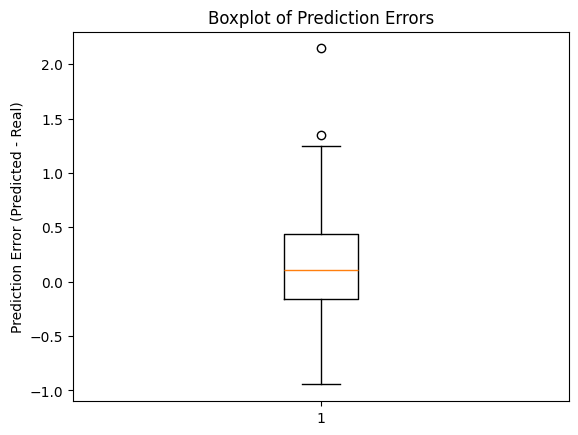

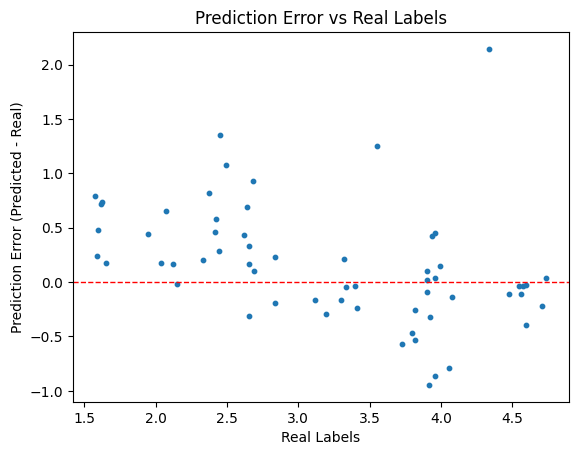

In [42]:
# Load the trained model weights
net.load_state_dict(torch.load(MODEL_PATH, map_location=device))
net.eval()
print(f"Model loaded from {MODEL_PATH}.")

# Calculate predicted labels
labels_val_predicted = []
with torch.no_grad():
    valid_mse = 0.0
    valid_mae = 0.0
    valid_size = 0
    for _, (batch_val_images, batch_val_labels) in enumerate(validloader):

        # Load data
        batch_val_images = batch_val_images.type(torch.float).to(device)
        batch_val_labels = batch_val_labels.type(torch.float).view(-1).cpu().numpy()

        # Calculate predicted labels
        outputs, _ = net(batch_val_images)
        outputs = outputs.view(-1).cpu().numpy()
        labels_val_predicted.extend(outputs)

# Turn to `numpy.array`
labels_val_real = labels_val.numpy()
labels_val_predicted = np.array(labels_val_predicted)

# Unnormalize labels
labels_val_real = labels_val_real * (MAX_LABEL - MIN_LABEL) + MIN_LABEL
labels_val_predicted = labels_val_predicted * (MAX_LABEL - MIN_LABEL) + MIN_LABEL

# Turn to `pandas.Series`
labels_val_real = pd.Series(labels_val_real)
labels_val_predicted = pd.Series(labels_val_predicted)
labels_val_diff = labels_val_predicted - labels_val_real

# Create `pandas.DataFrame`
df = pd.DataFrame(
    {
        "Real Labels": labels_val_real,
        "Predicted Labels": labels_val_predicted,
        "Diff": labels_val_diff,
        "MAPE": 1 - np.abs(labels_val_diff) / labels_val_real
    }
)
df.to_csv(OUTPUT_PATH, index = False)
print(df)
print(f"MAPE: {df["MAPE"].mean()}")

# Boxplot of the differences
plt.boxplot(labels_val_diff)
plt.ylabel("Prediction Error (Predicted - Real)")
plt.title("Boxplot of Prediction Errors")
plt.show()

# Plot the differences by the real labels.
plt.scatter(labels_val_real, labels_val_diff, s=10)
plt.xlabel("Real Labels")
plt.ylabel("Prediction Error (Predicted - Real)")
plt.title("Prediction Error vs Real Labels")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.show()